In [1]:
from IPython.core.display import display,Markdown

# <p style="background-color:#535353;font-family:newtimeroman;color:#FFF9ED;font-size:250%;text-align:center;border-radius:10px 10px;">SaaS Company EDA</p>



# <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:150%;text-align:left;border-radius:10px 10px;">Module Imports</p>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
import datetime
import plotly.graph_objects as go
import plotly.express as px
import math


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:150%;text-align:left;border-radius:10px 10px;">Table/Data Imports</p>


In [5]:
# Importing tables
subs = pd.read_csv("../input/sasscompanydataset/data/subscriptions.csv",
                   parse_dates=["created_at", "cancelled_at"])\
                   .drop("Unnamed: 0", axis=1)
subs.rename(columns={"id":"subs_id",
                     "created_at":"subs_created_at",
                     "cancelled_at":"subs_cancelled_at"}, inplace=True)

accs = pd.read_csv("../input/sasscompanydataset/data/accounts.csv").drop("Unnamed: 0", axis=1)

usrs = pd.read_csv("../input/sasscompanydataset/data/users.csv",
                   parse_dates=["created_at"]).drop("Unnamed: 0", axis=1)
usrs.rename(columns={"id":"user_id",
                     "created_at":"usrs_created_at",
                     "state":"usrs_state"}, inplace=True)

dvcs = pd.read_csv("../input/sasscompanydataset/data/devices.csv",
                   parse_dates=["created_at"]).drop("Unnamed: 0", axis=1)
dvcs.rename(columns={"id":"dvcs_id",
                     "created_at":"dvcs_created_at",
                     "state":"dvcs_state"}, inplace=True)


In [6]:
print(f"{subs.head()} \n\n{subs.info()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subs_id              1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1504 non-null   float64       
 5   plan_amount          1504 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   subs_created_at      1924 non-null   datetime64[ns]
 10  subs_cancelled_at    1053 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB
      subs_i

### <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:250%;text-align:left;border-radius:10px 10px;">Table SUBS Summary</p>
<div class="alert alert-info" role="alert">

- Found 420 NaNs in plan_unit_price column. Values filled in by calculating the means of their respective plans associated.

- Found 420 NaNs in plan_amount columm. Values filled in by multiplying plan_unit_price x plan_quantity.

- Found 871 NaTs in subs_cancelled_at. Values filled in with today's (today = whenever the nb is run) date.

- Found 20 NaNs in mrr column. Filled most of them with 0.

- Generated barplots and boxplots to see data distribution.
</div>


In [7]:
#Checking NaT's that are not related to active status
grp_count = subs.groupby(["status"])["subs_cancelled_at"].count()

#Checking active and future status
act_count = subs.loc[subs["status"] == "active"]["status"].count()
fut_count = subs.loc[subs["status"] == "future"]["status"].count()

print(f"{grp_count}\n\n Groupby result shows distribution of non NaT's in \
\033[1mcancelled_at\033[0m column; at the other hand active \033[1mstatus\033[0m count of \
\033[1m{act_count}\033[0m and future status count of {fut_count} sum up the remaining \
amount to complete \033[1m1924\033[0m observations.")


status
active             0
cancelled       1045
future             0
in_trial           6
non_renewing       2
Name: subs_cancelled_at, dtype: int64

 Groupby result shows distribution of non NaT's in cancelled_at column; at the other hand active status count of 857 and future status count of 11 sum up the remaining amount to complete 1924 observations.


<div class="alert alert-info" role="alert">
Null elements detected in: subscriptions.

Null elements in subscriptions table are located at:

- plan_unit_price: float type. Null elements most probably can be interpolated by calculating the means of their respective plans.
- plan_amount: float type. It seems that plan_amount is calculated as plan_quantity times -- plan_unit_price, so interpolating plan_unit_price should be enough to find null values in this column.
- subs_cancelled_at: this values are probably missing because they indicate when a plan has been (or will be) cancelled. From the groupby it is posible to see that Nat's are divided on two categories: active, future. Active status count is 857, so the other 14 NaT's count should be allocated at "future" status.
- mrr: since it's a calculation it will be calculated as means per similar plans.
</div>

In [8]:
# counting plan categories
plan_count = subs.groupby(["plan"])["plan_unit_price"].count()

# counting not-null plan_unit_price plan categories
notnull = subs[subs["plan_unit_price"].notna()]
notnull_count = notnull.groupby("plan")["plan_unit_price"].mean()

print(f"plan_count has \033[1m{plan_count.count()}\033[0m elements, while notnull_count \
has \033[1m{notnull_count.count()}\033[0m elements. There are \
\033[1m{abs(plan_count.count() - notnull_count.count())}\033[0m missing elements")


plan_count has 17 elements, while notnull_count has 14 elements. There are 3 missing elements


In [9]:
# checking missing categories
l1 = plan_count.reset_index().plan.to_list()
l2 = notnull_count.reset_index().plan.to_list()

miss_cat = []
for l in l1:
    if l not in l2:
        miss_cat.append(l)

print(f"Missing categories with plan_unit_price are contained in {miss_cat}. This should \
be obvious since no price would be assigned to a free or trial plan.\n\nThis three \
categories will have assigned to them the value of 0 to their plan_unit_price")

Missing categories with plan_unit_price are contained in ['free-yearly', 'regalo-yearly', 'trial-daily']. This should be obvious since no price would be assigned to a free or trial plan.

This three categories will have assigned to them the value of 0 to their plan_unit_price


In [10]:
# Converting non null unit prices to means using plan as grouping criteria
# pup: plan unit price
mean_pup = notnull.groupby(["plan"])["plan_unit_price"].mean()
mean_pup = mean_pup.to_dict()

# mean_pup onverted to dict to properly use it to map new values in NaN's
# will manually add the values for the free categories
for miss in miss_cat:
    mean_pup[miss] = 0

mean_pup


{'empresa-monthly': 1.6460000000000001,
 'empresa-yearly': 16.802345679012348,
 'empresa-yearly-2': 34.85272727272727,
 'empresa-yearly-3': 35.695,
 'empresa-yearly-4': 46.809285714285714,
 'familia-monthly': 15.0,
 'familia-yearly': 162.0,
 'individual-monthly': 5.0,
 'individual-yearly': 54.0,
 'nonprofit-monthly': 0.98,
 'nonprofit-yearly': 9.865,
 'nonprofit-yearly-2': 17.5,
 'nonprofit-yearly-3': 21.115000000000002,
 'nonprofit-yearly-4': 24.132,
 'free-yearly': 0,
 'regalo-yearly': 0,
 'trial-daily': 0}

In [11]:
# Mapping dict values into plan_unit_price NaNs
subs["plan_unit_price"] = subs.plan_unit_price.fillna(subs.plan.map(mean_pup))

# Calculating plan_amount NaNs as: plan_unit_price * plan_quantity
subs["plan_amount"] = subs.plan_amount.fillna(
    subs.plan_quantity * subs.plan_unit_price)

# Rounding to two decimals
subs[["plan_unit_price", "plan_amount"]] = subs[["plan_unit_price",
                                                 "plan_amount"]].round(2)

print(f"{subs.info()})\n\nThe result from .info() method shows a successful fillna process \
at both\033[1m plan_unit_price \033[0mand \033[1mplan_amount\033[0m columns.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subs_id              1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   subs_created_at      1924 non-null   datetime64[ns]
 10  subs_cancelled_at    1053 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB
None)

The r

<div class="alert alert-success" role="alert">

As explained before, NaTs values in subs_cancelled_at column will be filled with today's date in order to perform future data examination regarding to subscriptions lasting time.

Since datetime will be used to fillna, today's date will always be today's date when the notebook is opened and run.
</div>


In [12]:
subs["subs_cancelled_at"] = subs.subs_cancelled_at.fillna(pd.to_datetime("today"))
subs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subs_id              1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   subs_created_at      1924 non-null   datetime64[ns]
 10  subs_cancelled_at    1924 non-null   datetime64[ns]
 11  mrr                  1904 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 180.5+ KB


In [13]:
# subset shows that mrr NaNs are mainly composed of "trial-daily" plans
mrr_na = subs[subs["mrr"].isna()].groupby("plan")["subs_created_at"].count()

# Trying to figure out a way to determine mrr for the missing value
subs["ratio"] = subs["mrr"] / subs["plan_amount"]

mrr_nonprofit = subs[subs["plan"] == "nonprofit-yearly-4"][["plan", "mrr",
                                                            "ratio"]]
mrr_trialdaily = subs[subs["plan"] == "trial-daily"][["mrr", "ratio"]]

nnprft_mrrmean = mrr_nonprofit.groupby(["plan"])["ratio"].mean()
nnprft_mrrmean = nnprft_mrrmean.values.round(2)

print(f"Acoording to mrr_na, there are {mrr_na[1]} NaNs associated to trial-daily plans, \
and {mrr_na[0]} associated to a nonprofit-yearly-4 plan.\n\nFrom the looks of \
mrr_trialdaily, these NaN values will be filled with 0 and for the case of the missing \
nonprofit-yearly-4 plan it will filled using plan_amount times {nnprft_mrrmean} which is \
the mean of the mrrplan_amount ratio for that plan")


Acoording to mrr_na, there are 19 NaNs associated to trial-daily plans, and 1 associated to a nonprofit-yearly-4 plan.

From the looks of mrr_trialdaily, these NaN values will be filled with 0 and for the case of the missing nonprofit-yearly-4 plan it will filled using plan_amount times [1.79] which is the mean of the mrrplan_amount ratio for that plan


In [14]:
# dict for mrr filling NaNs
mrr_dict = {'trial-daily': 0, 'nonprofit-yearly-4': nnprft_mrrmean}

# mapping dict values
subs["mrr"] = subs.mrr.fillna(subs.plan.map(mrr_dict) * subs.plan_amount)

# checking current state of DF
subs[subs["plan"] == "nonprofit-yearly-4"][["plan", "mrr", "ratio"]]

# converting subs.mrr into int type
subs["mrr"] = subs.mrr.astype("int")
subs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subs_id              1924 non-null   object        
 1   customer_id          1924 non-null   object        
 2   plan                 1924 non-null   object        
 3   plan_quantity        1924 non-null   int64         
 4   plan_unit_price      1924 non-null   float64       
 5   plan_amount          1924 non-null   float64       
 6   billing_period       1924 non-null   int64         
 7   billing_period_unit  1924 non-null   object        
 8   status               1924 non-null   object        
 9   subs_created_at      1924 non-null   datetime64[ns]
 10  subs_cancelled_at    1924 non-null   datetime64[ns]
 11  mrr                  1924 non-null   int64         
 12  ratio                1504 non-null   float64       
dtypes: datetime64[ns](2), float64(3),

In [15]:
# creating timedelta object for duration of plans
subs["subs_duration"] = subs.subs_cancelled_at - subs.subs_created_at


### <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:250%;text-align:left;border-radius:10px 10px;">Plans Distribution Plots</p>


In [16]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [17]:
# styling the graphs
plt.style.use("seaborn-poster")

# going for barplot vs accumulated curve.
series_plan = subs.groupby(["plan"])["plan_quantity"].sum().sort_values(
    ascending=False)

# Creating columns to reflect cumulative values
plan_df = pd.DataFrame(series_plan).reset_index()
plan_df["values_norm"] = plan_df.plan_quantity / plan_df.plan_quantity.sum()
plan_df["cumulative"] = plan_df.values_norm.cumsum()
plan_df["perc_cumulative"] = plan_df.cumulative / plan_df.cumulative.max()
plan_df["perc_cum_label"] = plan_df.apply(
    lambda x: str(round(x.perc_cumulative, 2)), axis=1)


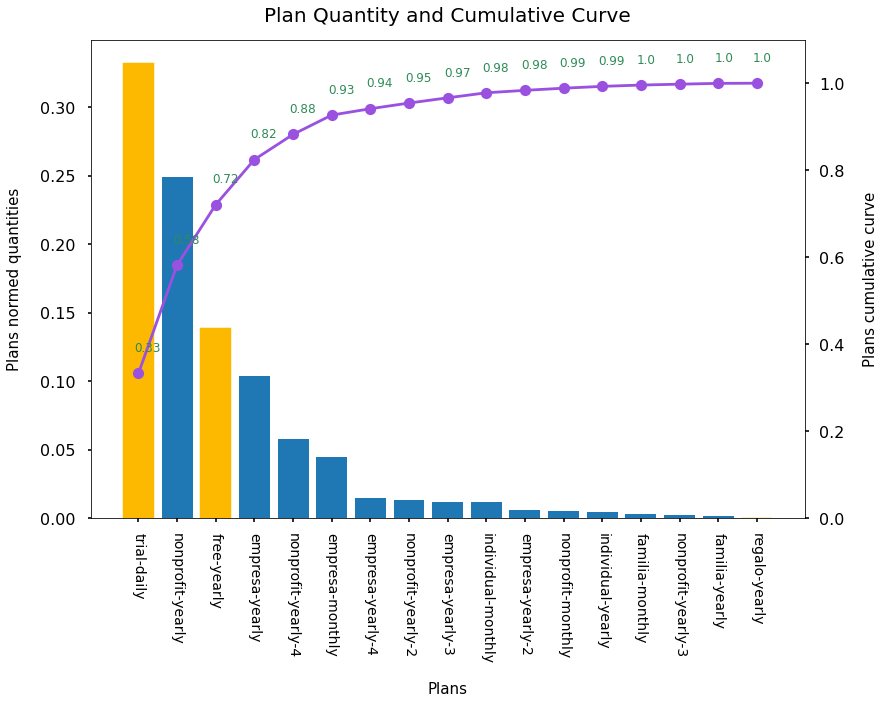

In [18]:
# generating figure and twin axes
plt.figure()
host = host_subplot(111)
par = host.twinx()

# we plot the bars (use host. instead of plt.)
x = np.array(plan_df['plan'])
y = np.array(plan_df['values_norm'])
p1 = host.bar(x, y)

# changing color for free plans
p1.patches[0].set_color("#fcb900")
p1.patches[2].set_color("#fcb900")
p1.patches[16].set_color("#fcb900")

# plotting the curve (use par. instead of plt.)
x = list(range(len(x)))
y = list(plan_df['perc_cumulative'])

p2 = par.plot(x, y, color="#9b51e0",marker='o')

# plotting the values from the cumulative curve on top of it
y_labels = list(plan_df['perc_cum_label'])
for i,j in zip(x,y):
    inplot = par.annotate(str(y_labels[i]), xy=(i-0.1,j+0.05), fontsize=12,
                          color='seagreen')

   
# some final tweaking in title, axis and labels
par.axis(ymin=0, ymax=1.1)
plt.title('Plan Quantity and Cumulative Curve', fontsize=20, pad=18)
host.set_xlabel('Plans', size=15, labelpad=18)
host.set_ylabel('Plans normed quantities', size=15, labelpad=18)
par.set_ylabel('Plans cumulative curve', size=15, labelpad=18)
host.tick_params(axis='x', labelsize = 14, labelrotation=-90)

# saving files to dir
plt.savefig(f"Plan_quantity_cumulative_curve.png",
            bbox_inches = 'tight')
plt.show()


<div class="alert alert-warning" role="alert">From the barplot, it's pretty clear that trial-daily has about 33% of plan quantity and if paired with free-yearly and regalo-yearly they would up to almost 50%.
Lets check out fowithout free plans accounts.
</div>

In [19]:
# Creating columns to reflect cumulative values (having removed free plans)
plan_nofree = pd.DataFrame(series_plan).reset_index()
plan_nofree = plan_nofree.drop([0, 2, 16]).reset_index()
plan_nofree = plan_nofree.drop("index", axis=1)
plan_nofree["values_norm"] = plan_nofree.plan_quantity / \
    plan_nofree.plan_quantity.sum()
plan_nofree["cumulative"] = plan_nofree.values_norm.cumsum()
plan_nofree["perc_cumulative"] = plan_nofree.cumulative / \
    plan_nofree.cumulative.max()
plan_nofree["perc_cum_label"] = plan_nofree.apply(
    lambda x: str(round(x.perc_cumulative, 2)), axis=1)


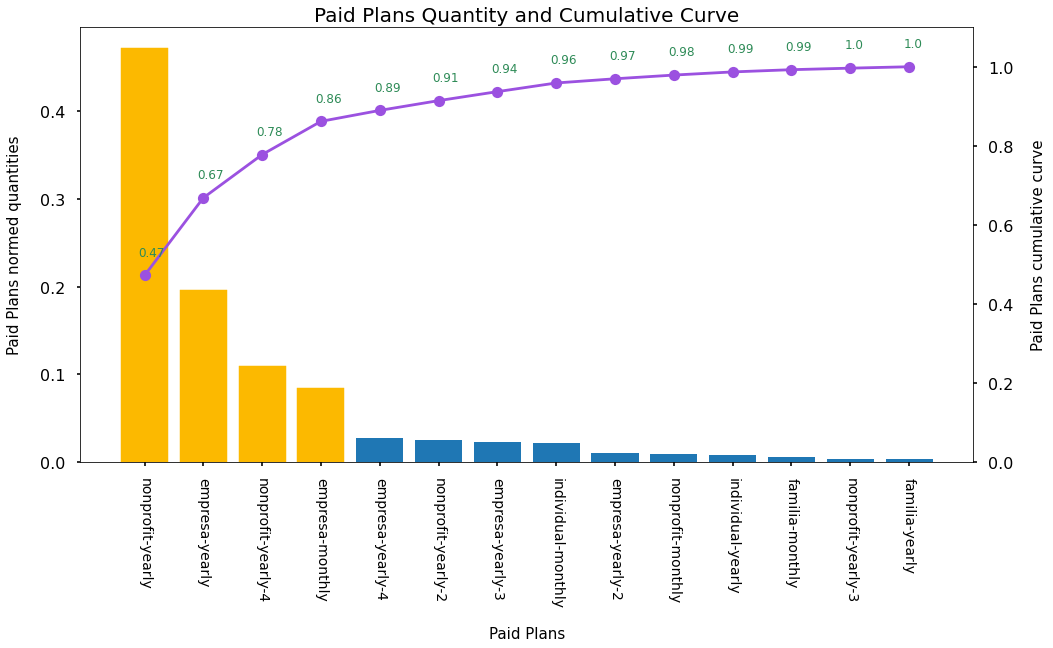

In [20]:
# generating figure and twin axes
plt.figure(figsize=(16, 8))
host = host_subplot(111)
par = host.twinx()

# we plot the bars (use host. instead of plt.)
x = np.array(plan_nofree['plan'])
y = np.array(plan_nofree['values_norm'])
p1 = host.bar(x, y)

# changing color for largest plans
for i in range(4):
    p1.patches[i].set_color("#fcb900")

# plotting the curve (use par. instead of plt.)
x = list(range(len(x)))
y = list(plan_nofree['perc_cumulative'])
p2 = par.plot(x, y, color="#9b51e0",marker='o')

# plotting the values from the cumulative curve on top of it
y_labels = list(plan_nofree['perc_cum_label'])
for i,j in zip(x,y):
    inplot = par.annotate(str(y_labels[i]), xy=(i-0.1,j+0.05), fontsize=12,
                          color='seagreen')
    
# some final tweaking in title, axis and labels
par.axis(ymin=0, ymax=1.1)
plt.title('Paid Plans Quantity and Cumulative Curve', fontsize=20)
host.set_xlabel('Paid Plans', size=15, labelpad=18)
host.set_ylabel('Paid Plans normed quantities', size=15, labelpad=18)
par.set_ylabel('Paid Plans cumulative curve', size=15, labelpad=18)
host.tick_params(axis="x", labelsize = 14, labelrotation=-90)

# saving files to dir
plt.savefig(f"Paid_Plans_quantity_cumulative_curve.png",
            bbox_inches = 'tight')
plt.show()

In [21]:
series_plan = subs.groupby(["plan", "status"])["plan_quantity"].sum().\
    sort_values(ascending=False)

free_plans = ["trial-daily", "free-yearly", "regalo-yearly"]

# Creating new DF
plan_df = pd.DataFrame(series_plan).reset_index()

# Dropping free plans
for free in free_plans:
    plan_df = plan_df[plan_df.plan != free]

# Creating columns to reflect cumulative values
plan_df["values_norm"] = plan_df.plan_quantity / plan_df.plan_quantity.sum()
plan_df["cumulative"] = plan_df.values_norm.cumsum()
plan_df["perc_cumulative"] = plan_df.cumulative / plan_df.cumulative.max()
plan_df["perc_cum_label"] = plan_df.apply(
      lambda x: str(round(x.perc_cumulative * 100, 1)) + "%", axis=1)

#Dropping plans past 0.86 cumulative
top85 = plan_df[plan_df["cumulative"] <= 0.86]
top85[["plan", "status"]] = top85[["plan", "status"]].astype("category")
top85 = top85.groupby(["plan", "status"])["plan_quantity"].sum().fillna(0)
top85 = pd.DataFrame(top85).reset_index()

top85


,plan,status,plan_quantity
0,empresa-monthly,active,2593
1,empresa-monthly,cancelled,0
2,empresa-yearly,active,5062
3,empresa-yearly,cancelled,1371
4,nonprofit-yearly,active,11827
5,nonprofit-yearly,cancelled,3576
6,nonprofit-yearly-4,active,3469
7,nonprofit-yearly-4,cancelled,0


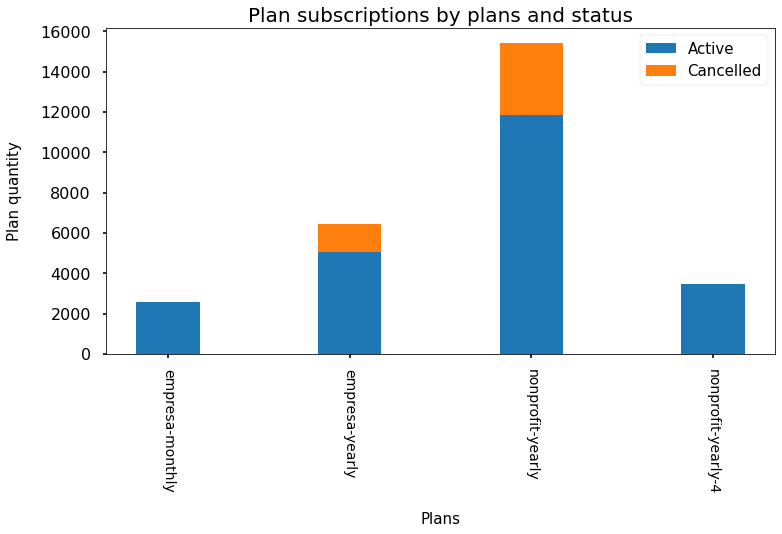

In [22]:
labels = top85.plan.unique().tolist()

active = top85["plan_quantity"][top85["status"] == "active"].to_list()
cancelled = top85["plan_quantity"][top85["status"] == "cancelled"].to_list()

# plotting the stacked histogram
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(labels, active, width=0.35, label='Active')
ax.bar(labels, cancelled, width=0.35, bottom=active, label='Cancelled')

ax.set_ylabel('Plan quantity', fontsize=15, labelpad=18)
ax.set_xlabel('Plans', fontsize=15, labelpad=18)
ax.set_title('Plan subscriptions by plans and status', fontsize=20)
ax.tick_params(axis="x", labelsize = 14, labelrotation=-90)
ax.legend(fontsize=15)

plt.show()


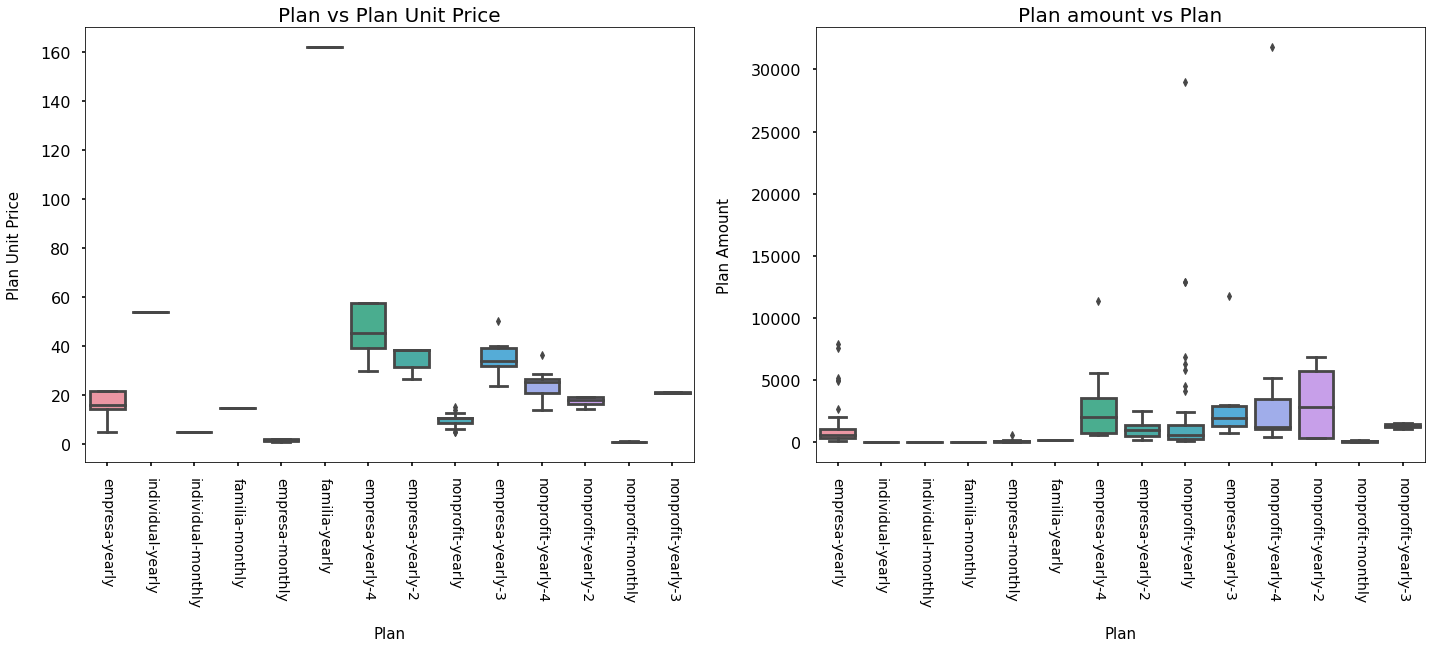

In [23]:
# Removing free plans of this calculation
boxplot_df = subs[subs.plan_unit_price != 0]

# setting up boxplot
fig, axs = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="plan", y="plan_unit_price", data=boxplot_df, ax=axs[0])
axs[0].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[0].set_title('Plan vs Plan Unit Price', fontsize=20)
axs[0].set_xlabel("Plan", size=15, labelpad=18)
axs[0].set_ylabel("Plan Unit Price", size=15, labelpad=18)

sns.boxplot(x="plan", y="plan_amount", data=boxplot_df, ax=axs[1])
axs[1].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[1].set_title('Plan amount vs Plan', fontsize=20)
axs[1].set_xlabel("Plan", size=15, labelpad=18)
axs[1].set_ylabel("Plan Amount", size=15, labelpad=18)

# saving files to dir
plt.savefig(f"Plan_boxplots_1.png", bbox_inches = 'tight')
plt.show()

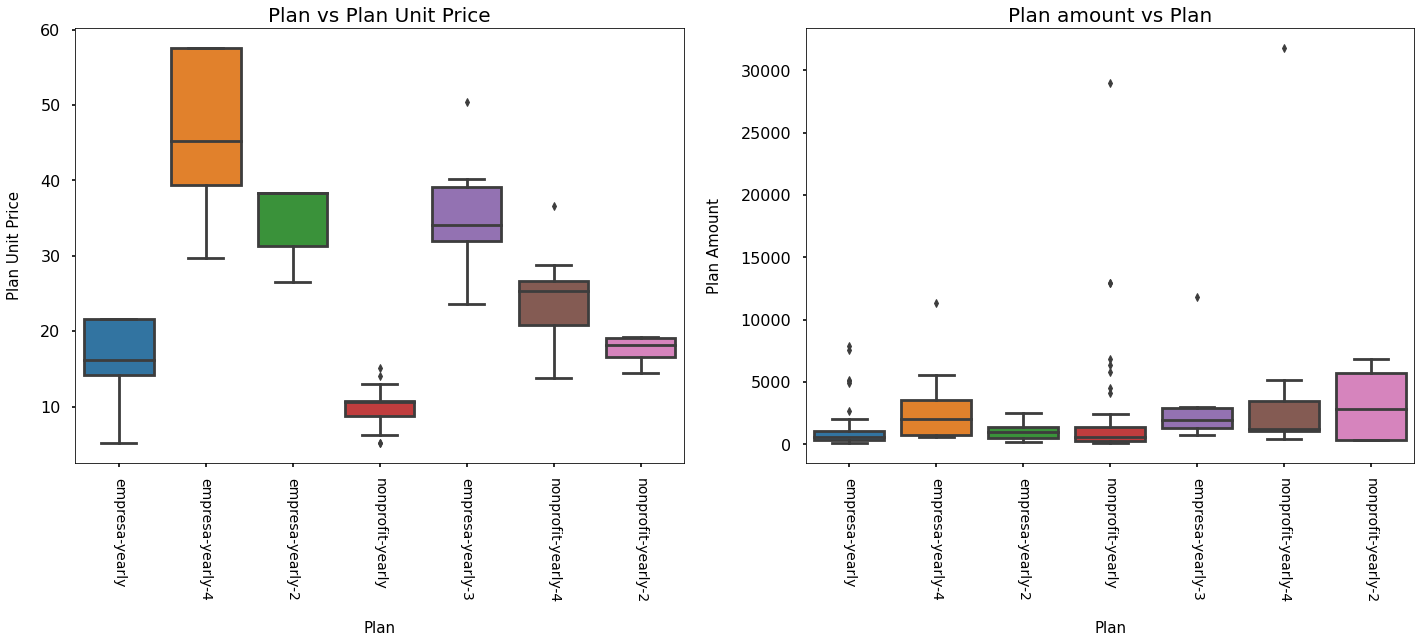

In [24]:
# Removing free plans of this calculation
boxplot_df2 = subs[subs.plan_unit_price != 0]

# removing plans with low variance
low_var = ["individual-yearly", "individual-monthly", "familia-monthly",
           "empresa-monthly", "familia-yearly", "nonprofit-monthly",
           "nonprofit-yearly-3"]

for plan in low_var:
    boxplot_df2 = boxplot_df2[boxplot_df2.plan != plan]

# setting up boxplot
fig, axs = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="plan", y="plan_unit_price", data=boxplot_df2, ax=axs[0])
axs[0].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[0].set_title('Plan vs Plan Unit Price', fontsize=20)
axs[0].set_xlabel("Plan", size=15, labelpad=18)
axs[0].set_ylabel("Plan Unit Price", size=15, labelpad=18)

sns.boxplot(x="plan", y="plan_amount", data=boxplot_df2, ax=axs[1])
axs[1].tick_params(axis='x', labelsize = 14, labelrotation=-90)
axs[1].set_title('Plan amount vs Plan', fontsize=20)
axs[1].set_xlabel("Plan", size=15, labelpad=18)
axs[1].set_ylabel("Plan Amount", size=15, labelpad=18)

# saving files to dir
plt.savefig(f"Plan_boxplots_2.png", bbox_inches = 'tight')
plt.show()


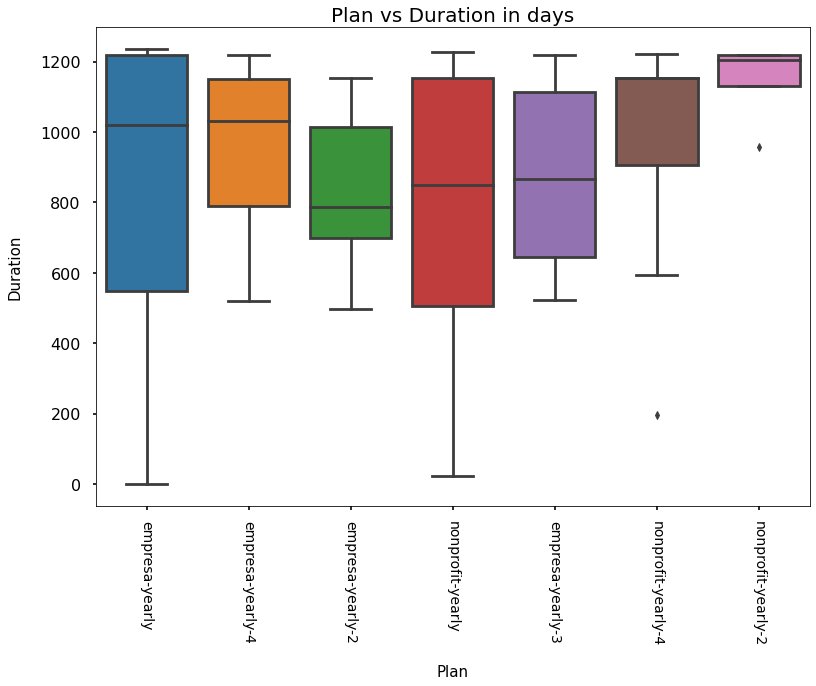

In [25]:
# setting up boxplot for plan duration in days
boxplot_df3 = boxplot_df2
boxplot_df3["subs_duration"] = boxplot_df3.subs_duration.dt.days
fig = plt.figure()
ax = fig.gca()

sns.boxplot(x="plan", y="subs_duration", data=boxplot_df3, ax=ax)
ax.tick_params(axis='x', labelsize = 14, labelrotation=-90)
ax.set_title('Plan vs Duration in days', fontsize=20)
ax.set_xlabel("Plan", size=15, labelpad=18)
ax.set_ylabel("Duration", size=15, labelpad=18)

# saving file to dir
plt.savefig(f"Plan_boxplots_3.png", bbox_inches = 'tight')
plt.show()


In [26]:
# subsetting "cancelled" and "non_renewing" subscriptions
cancelled = subs[subs["status"].isin(["cancelled", "non_renewing"])]
cancelled.groupby(["plan"])["customer_id"].count()


plan
empresa-monthly         7
empresa-yearly         20
empresa-yearly-2        1
empresa-yearly-3        2
familia-monthly        93
familia-yearly         39
free-yearly            37
individual-monthly    530
individual-yearly      78
nonprofit-monthly       2
nonprofit-yearly       11
nonprofit-yearly-4      2
trial-daily           225
Name: customer_id, dtype: int64

In [27]:
# getting rid of free and trial plans because those are not paid plans
cancelled = cancelled[~cancelled["plan"].isin(["free-yearly", "trial-daily"])]

# converting timedelta "subs_duration" to int type
cancelled["subs_duration"] = cancelled.subs_duration.dt.days.astype("int")


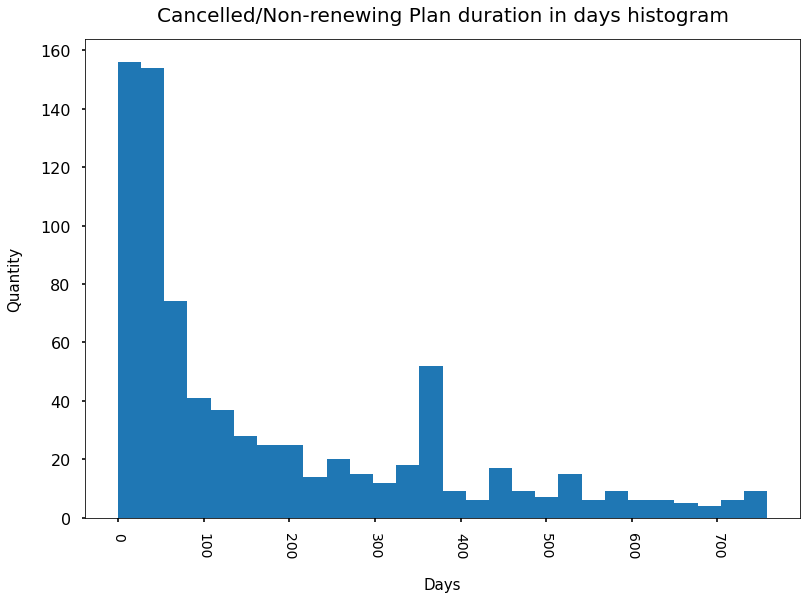

In [28]:
# checking on duration of cancelled/non-renewing subscriptions
fig = plt.figure()
ax = fig.gca()

bins = int(math.sqrt(cancelled.subs_duration.count()))

ax = plt.hist(cancelled.subs_duration, bins=bins)
plt.title("Cancelled/Non-renewing Plan duration in days histogram", size="20", pad=18)
plt.xlabel("Days", size=15, labelpad=18)
plt.ylabel("Quantity", size=15, labelpad=18)
plt.tick_params(axis="x", labelsize=14, labelrotation=-90)

plt.savefig(f"CancelledNonRenewing_duration_histogram.png",
            bbox_inches = 'tight')
plt.show()


<div class="alert alert-warning" role="alert"> Bummer. I was expecting to see a normal-like distribution so I could perform a test to verify or reject that assumption. It is very clear that this is not the case, at least for all plans at once. I'll try again creating one histogram per plan billing period unit.

According to this histogram, most cancelled/non-renewing plans are terminated within the first 100 days.</div>



In [29]:
# checking that billing_period_unit correlates to plan's names
cancelled.groupby(["billing_period_unit", "plan"])["subs_duration"].count()


billing_period_unit  plan              
month                empresa-monthly         7
                     familia-monthly        93
                     individual-monthly    530
                     nonprofit-monthly       2
year                 empresa-yearly         20
                     empresa-yearly-2        1
                     empresa-yearly-3        2
                     familia-yearly         39
                     individual-yearly      78
                     nonprofit-yearly       11
                     nonprofit-yearly-4      2
Name: subs_duration, dtype: int64

<div class="alert alert-success" role="alert">From the groupby operation it's pretty clear that individual-monthly is by far the most cancelled/non-renewing plan. If anything, individual-monthly should be targeted by marketing teams to develop retention strategies before the 100 days limit.
</div>


In [30]:
monthly = cancelled.loc[cancelled["billing_period_unit"] == "month"]
yearly = cancelled.loc[cancelled["billing_period_unit"] == "year"]


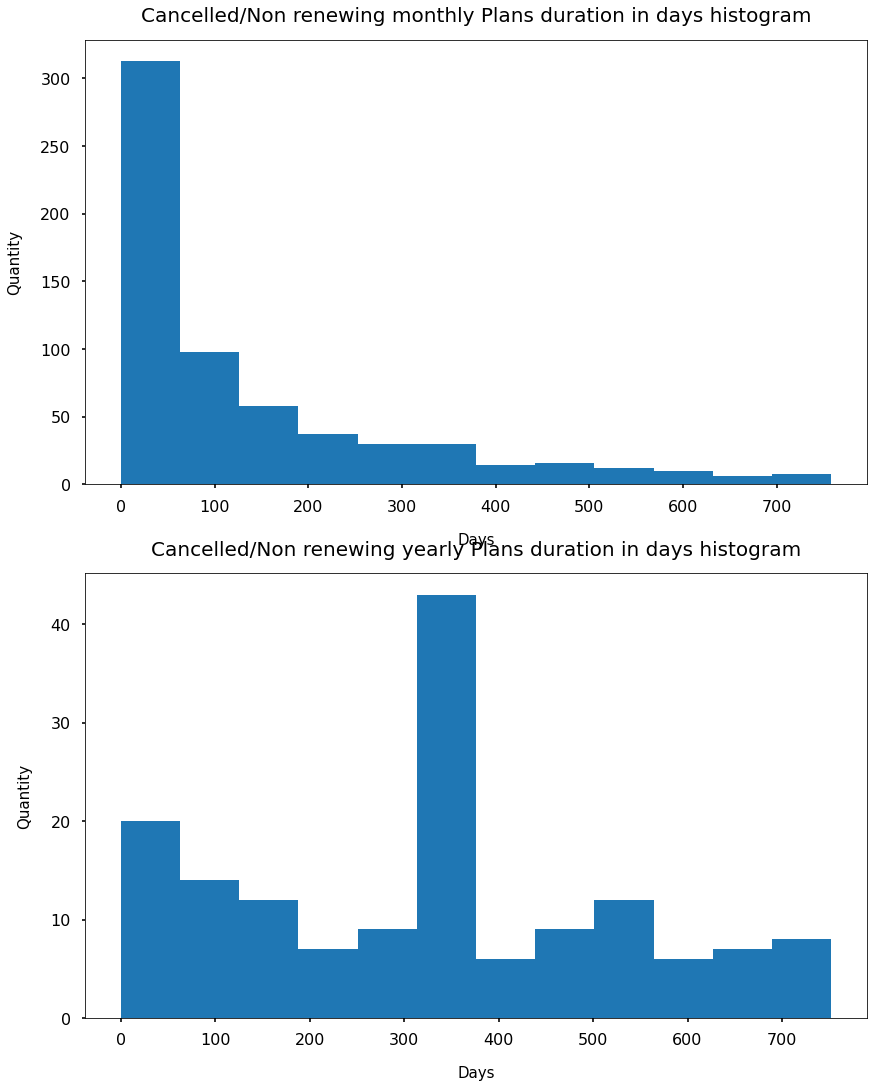

In [31]:
bins = min(int(math.sqrt(monthly.subs_duration.count())),
           int(math.sqrt(yearly.subs_duration.count())))

# subplotting according to billing period unit
fig, axs = plt.subplots(2, 1, sharex=False, figsize=(14, 18))

axs[0].hist(monthly.subs_duration, bins=bins)
axs[0].set_title("Cancelled/Non renewing monthly Plans duration in days histogram",
                 size="20", pad=18)
axs[0].set_xlabel("Days", size=15, labelpad=18)
axs[0].set_ylabel("Quantity", size=15, labelpad=18)

axs[1].hist(yearly.subs_duration, bins=bins)
axs[1].set_title("Cancelled/Non renewing yearly Plans duration in days histogram",
                 size="20", pad=18)
axs[1].set_xlabel("Days", size=15, labelpad=18)
axs[1].set_ylabel("Quantity", size=15, labelpad=18)

plt.savefig(f"CancelledNonRenewing_duration_histogram2.png",
            bbox_inches = 'tight')
plt.show()


### <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:250%;text-align:left;border-radius:10px 10px;">Table DVCS Summary</p>
- DVCS table has not a single NaN value on any of its colums.


In [32]:
# basic review of dvcs table
print(f"{dvcs.info()}\n\n{dvcs.head()})")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56240 entries, 0 to 56239
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dvcs_id          56240 non-null  object        
 1   user_id          56240 non-null  object        
 2   dvcs_created_at  56240 non-null  datetime64[ns]
 3   type             56240 non-null  object        
 4   os               56240 non-null  object        
 5   dvcs_state       56240 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.6+ MB
None

      dvcs_id     user_id     dvcs_created_at    type       os dvcs_state
0  b4ac4cfb6a  f76d3628cb 2013-02-12 13:46:37   Phone  Android    deleted
1  3740780237  f76d3628cb 2014-04-11 08:32:44  Tablet  Android    deleted
2  3a78940895  f76d3628cb 2014-04-19 14:52:01  Tablet  Android    deleted
3  74ab455a9d  f76d3628cb 2015-04-20 15:51:23   Phone  Android    deleted
4  400458972f  f76d3628cb 2016-06


 Changing **type**, **os**, and **state** columns to category type reduced the memory usage from 2.6MB to 1.4MB. Memory saving might not be a big deal for such a reduced DataFrame object but it might come in handy if we have to increase it's size.



In [33]:
# categories by size
print(f" type has {len(dvcs.type.unique())} categories\n os has {len(dvcs.os.unique())} \
categories\n state has {len(dvcs.dvcs_state.unique())} categories")

# basic data distribution going from less to more categories
dvcs.groupby(["type", "dvcs_state", "os"])[["user_id", "dvcs_id"]].count()


 type has 4 categories
 os has 16 categories
 state has 4 categories


user_id  dvcs_id
type    dvcs_state os                          
Desktop deleted    Centos            1        1
                   Debian            1        1
                   Mac             611      611
                   Ubuntu            6        6
                   Windows        1604     1604
        missing    Mac               4        4
                   Windows          25       25
        ok         Mac             931      931
                   Ubuntu            3        3
                   Windows        1028     1028
        unverified Windows           1        1
Laptop  deleted    Android          82       82
                   Arch              6        6
                   Chrome            2        2
                   Debian            1        1
                   Linux             2        2
                   Mac            3278     3278
                   Mint             11       11
                   Neon              3        3
                   Ubuntu          158      158
                   Windows       11006    11006
        missing    Android           2        2
                   Mac              70       70
                   Windows         419      419
        ok         Android          95       95
                   Arch              3        3
                   Centos            2        2
                   Chrome            1        1
                   Debian            4        4
                   Elementary        1        1
                   Fedora            1        1
                   Kali              1        1
                   Mac            3353     3353
                   Mint              4        4
                   Neon              1        1
                   Solus             1        1
                   Ubuntu          157      157
                   Windows       21276    21276
        unverified Mac               1        1
Phone   deleted    Android        2951     2951
                   Ios            1319     1319
                   Linux             1        1
        missing    Android          81       81
                   Ios              37       37
        ok         Android        1430     1430
                   Ios             856      856
Tablet  deleted    Android        1235     1235
                   Ios            1568     1568
                   Mac               1        1
                   Windows          15       15
        missing    Android          10       10
                   Ios              14       14
        ok         Android        1426     1426
                   Ios            1139     1139
                   Windows           1        1

<div class="alert alert-success" role="alert"> 
From the groupby method I was expecting to find a different count between id and user_id, mostly having user_id <= id, indicating that one user can have more than one device. 
</div>                                                                                           Instead, the result shows that each user has one and only one device associated.Having this into consideration,let's groupby again, just taking id into consideration.

In [34]:
dvcs_gb = dvcs.groupby(["type", "dvcs_state", "os"])["dvcs_id"].count()
dvcs_gb = pd.DataFrame(dvcs_gb).reset_index()
dvcs_gb.rename(columns={"dvcs_id":"total"}, inplace=True)
dvcs_gb.sort_values(by="total", axis="rows", ascending=False, inplace=True)

dvcs_gb.head()


,type,dvcs_state,os,total
37,Laptop,ok,Windows,21276
20,Laptop,deleted,Windows,11006
32,Laptop,ok,Mac,3353
16,Laptop,deleted,Mac,3278
39,Phone,deleted,Android,2951


<div class="alert alert-info" role="alert">By converting os column into category type, additional rows were created because all categories should have a value, even if it is a zero (this is true for all categories, but os is relevant because as seen earlier it has 16 possible values). In order to deal with this issue I'll create an additional column to summarise less frequent OS. I'll follow an 80-20 rule for each type: OS on the 80% most frequent will be a category on its own while the OS on the 20% will go to a common bin.
</div>
 

In [35]:
# slicing according to type
dsk = dvcs_gb.loc[dvcs_gb["type"] == "Desktop"]
ltp = dvcs_gb.loc[dvcs_gb["type"] == "Laptop"]
phn = dvcs_gb.loc[dvcs_gb["type"] == "Phone"]
tbt = dvcs_gb.loc[dvcs_gb["type"] == "Tablet"]

df_lst = [dsk, ltp, phn, tbt]
for df in df_lst:
    df["values_norm"] = df.total / df.total.sum()
    df["cumulative"] = df.values_norm.cumsum()
    
print(f"{dsk.head()}\n\n{ltp.head()}\n\n{phn.head()}\n\n{tbt.head()}")

# setting up the limit at 0.995 instead of 0.8 because I want 3 
mfo_dsk, mfo_ltp, mfo_phn, mfo_tbt = \
    [df["os"][df["cumulative"] <= 0.995].unique() for df in df_lst]

print(f"{mfo_dsk}\n\n{mfo_ltp}\n\n{mfo_phn}\n\n{mfo_tbt}")


      type dvcs_state       os  total  values_norm  cumulative
4  Desktop    deleted  Windows   1604     0.380546    0.380546
9  Desktop         ok  Windows   1028     0.243891    0.624437
7  Desktop         ok      Mac    931     0.220878    0.845314
2  Desktop    deleted      Mac    611     0.144958    0.990273
6  Desktop    missing  Windows     25     0.005931    0.996204

      type dvcs_state       os  total  values_norm  cumulative
37  Laptop         ok  Windows  21276     0.532686    0.532686
20  Laptop    deleted  Windows  11006     0.275556    0.808242
32  Laptop         ok      Mac   3353     0.083949    0.892191
16  Laptop    deleted      Mac   3278     0.082071    0.974262
23  Laptop    missing  Windows    419     0.010490    0.984753

     type dvcs_state       os  total  values_norm  cumulative
39  Phone    deleted  Android   2951     0.442097    0.442097
44  Phone         ok  Android   1430     0.214232    0.656330
40  Phone    deleted      Ios   1319     0.197603    0.8

In [36]:
# Creating most frequent OS dictionaries
mfo_lst = [mfo_dsk, mfo_ltp, mfo_phn, mfo_tbt]
mfo_dsk_dict = {}; mfo_ltp_dict = {}; mfo_phn_dict = {}; mfo_tbt_dict = {}
mfo_dct = [mfo_dsk_dict, mfo_ltp_dict, mfo_phn_dict, mfo_tbt_dict]

for i in range(len(mfo_lst)):
    for j in range(len(mfo_lst[i])):
        mfo_dct[i][mfo_lst[i][j]] = mfo_lst[i][j]

print(f"DESKTOP most frequent OS dict is {mfo_dsk_dict}\n\
LAPTOP most frequent OS dict is {mfo_ltp_dict}\n\
PHONE most frequent OS dict is {mfo_phn_dict}\n\
TABLET most frequent OS dict is {mfo_tbt_dict}")


DESKTOP most frequent OS dict is {'Windows': 'Windows', 'Mac': 'Mac'}
LAPTOP most frequent OS dict is {'Windows': 'Windows', 'Mac': 'Mac', 'Ubuntu': 'Ubuntu'}
PHONE most frequent OS dict is {'Android': 'Android', 'Ios': 'Ios'}
TABLET most frequent OS dict is {'Ios': 'Ios', 'Android': 'Android'}


In [37]:
# mapping dict values into DataFrames
for i in range(len(df_lst)):
    df_lst[i]["os_1"] = df_lst[i].os.map(mfo_dct[i])
    df_lst[i]["os_1"] = df_lst[i].os_1.fillna("Other")
    df_lst[i]["os_1"] = df_lst[i].os_1.astype("category")

print(f"{dsk.head()}\n\n{ltp.head()}\n\n{phn.head()}\n\n{tbt.head()}")


      type dvcs_state       os  total  values_norm  cumulative     os_1
4  Desktop    deleted  Windows   1604     0.380546    0.380546  Windows
9  Desktop         ok  Windows   1028     0.243891    0.624437  Windows
7  Desktop         ok      Mac    931     0.220878    0.845314      Mac
2  Desktop    deleted      Mac    611     0.144958    0.990273      Mac
6  Desktop    missing  Windows     25     0.005931    0.996204  Windows

      type dvcs_state       os  total  values_norm  cumulative     os_1
37  Laptop         ok  Windows  21276     0.532686    0.532686  Windows
20  Laptop    deleted  Windows  11006     0.275556    0.808242  Windows
32  Laptop         ok      Mac   3353     0.083949    0.892191      Mac
16  Laptop    deleted      Mac   3278     0.082071    0.974262      Mac
23  Laptop    missing  Windows    419     0.010490    0.984753  Windows

     type dvcs_state       os  total  values_norm  cumulative     os_1
39  Phone    deleted  Android   2951     0.442097    0.442097  

In [38]:
dsk = pd.DataFrame(dsk.groupby(["dvcs_state", "os_1"])["total"].sum())
dsk = dsk.fillna(0).reset_index()
dsk_labels = dsk.dvcs_state.unique().tolist()
dsk = dsk.pivot(index=["os_1"], columns=["dvcs_state"], values=["total"])
dsk = np.array(dsk.reset_index())

ltp = pd.DataFrame(ltp.groupby(["dvcs_state", "os_1"])["total"].sum())
ltp = ltp.fillna(0).reset_index()
ltp_labels = ltp.dvcs_state.unique().tolist()
ltp = ltp.pivot(index=["os_1"], columns=["dvcs_state"], values=["total"])
ltp = np.array(ltp.reset_index())

phn = pd.DataFrame(phn.groupby(["dvcs_state", "os_1"])["total"].sum())
phn = phn.fillna(0).reset_index()
phn_labels = phn.dvcs_state.unique().tolist()
phn = phn.pivot(index=["os_1"], columns=["dvcs_state"], values=["total"])
phn = np.array(phn.reset_index())

tbt = pd.DataFrame(tbt.groupby(["dvcs_state", "os_1"])["total"].sum())
tbt = tbt.fillna(0).reset_index()
tbt_labels = tbt.dvcs_state.unique().tolist()
tbt = tbt.pivot(index=["os_1"], columns=["dvcs_state"], values=["total"])
tbt = np.array(tbt.reset_index())

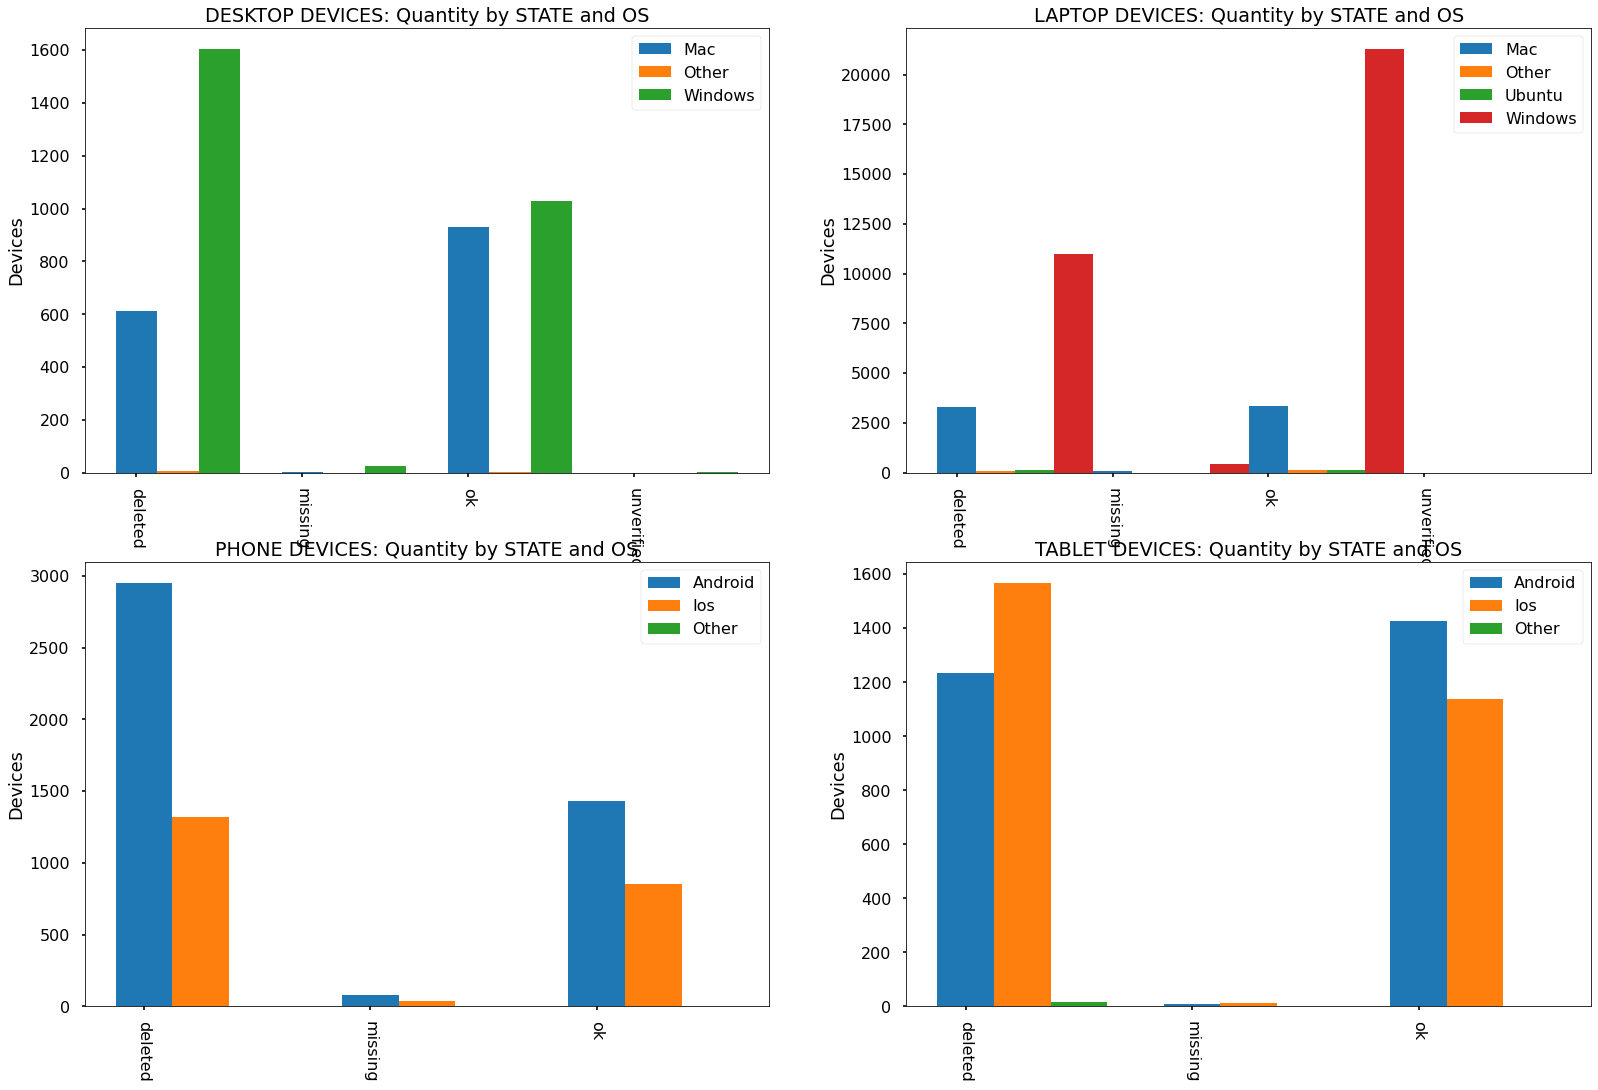

In [39]:
# Plot basic config
fig, axs = plt.subplots(2, 2, figsize=(27,18))
width = 0.25

# DESKTOP BARPLOT
x = np.arange(len(dsk_labels))
for i in range(dsk.shape[0]):
    axs[0, 0].bar(x + (width * i), height=dsk[i, 1:], width=width)

axs[0, 0].set_ylabel('Devices')
axs[0, 0].set_title('DESKTOP DEVICES: Quantity by STATE and OS')
axs[0, 0].set_xticks(x)
axs[0, 0].tick_params(axis='x', labelrotation=-90)
axs[0, 0].set_xticklabels(dsk_labels)
axs[0, 0].legend(dsk[:, 0])

# LAPTOP BARPLOT
x = np.arange(len(ltp_labels))
for i in range(ltp.shape[0]):
    axs[0, 1].bar(x + (width * i), height=ltp[i, 1:], width=width)

axs[0, 1].set_ylabel('Devices')
axs[0, 1].set_title('LAPTOP DEVICES: Quantity by STATE and OS')
axs[0, 1].set_xticks(x)
axs[0, 1].tick_params(axis='x', labelrotation=-90)
axs[0, 1].set_xticklabels(ltp_labels)
axs[0, 1].legend(ltp[:, 0])

# PHONE BARPLOT
x = np.arange(len(phn_labels))
for i in range(phn.shape[0]):
    axs[1, 0].bar(x + (width * i), height=phn[i, 1:], width=width)

axs[1, 0].set_ylabel('Devices')
axs[1, 0].set_title('PHONE DEVICES: Quantity by STATE and OS')
axs[1, 0].set_xticks(x)
axs[1, 0].tick_params(axis='x', labelrotation=-90)
axs[1, 0].set_xticklabels(phn_labels)
axs[1, 0].legend(phn[:, 0])

# TABLET BARPLOT
x = np.arange(len(tbt_labels))
for i in range(tbt.shape[0]):
    axs[1, 1].bar(x + (width * i), height=tbt[i, 1:], width=width)

axs[1, 1].set_ylabel('Devices')
axs[1, 1].set_title('TABLET DEVICES: Quantity by STATE and OS')
axs[1, 1].set_xticks(x)
axs[1, 1].tick_params(axis='x', labelrotation=-90)
axs[1, 1].set_xticklabels(tbt_labels)
axs[1, 1].legend(tbt[:, 0])

# saving to file and showing barplots
plt.savefig(f"Devices_barplots.png", bbox_inches = 'tight')
plt.show()

In [40]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

### <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:250%;text-align:left;border-radius:10px 10px;">Table USERS Summary</p>


In [41]:
usrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          2828 non-null   object        
 1   usrs_created_at  2828 non-null   datetime64[ns]
 2   country_name     2576 non-null   object        
 3   usrs_state       2828 non-null   object        
 4   account_id       2828 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 110.6+ KB


<div class="alert alert-info" role="alert">

- USRS has 252 missing values at country_name which is almost 10% of the total number of rows . Filled in missing values with "Antarctica".Since there's no value in either dropping them or naming them with a tag like "Unknown". Instead Antarctica will serve to plot them in the map Fig.

- USRS had some country names in a format not according to international ISO3 notation (ie: México instead of Mexico, or Estados Unidos instead of United States). This names were corrected in order to use plotly library.

</div>

In [42]:
# Filling NaNs with Antarctica for avoiding either dropping the values
# or having issues with plotly
usrs.country_name.fillna("Antarctica", inplace=True)
usrs.country_name.replace(["Anonymous Proxy"], "Antarctica", inplace=True)

# Countries to ISO3 format
usrs.country_name.replace(["Brasil"], "Brazil", inplace=True)
usrs.country_name.replace(["Estados Unidos"], "United States", inplace=True)
usrs.country_name.replace(["México"], "Mexico", inplace=True)
usrs.country_name.replace(["Cote d'Ivoire"], "Ivory Coast", inplace=True)
usrs.country_name.replace(["Russian Federation"], "Russia", inplace=True)
usrs.country_name.replace(["Korea, Republic of"], "South Korea", inplace=True)
usrs.country_name.replace(["Viet Nam"], "Vietnam", inplace=True)
usrs.country_name.replace(["Korea, Republic of"], "South Korea", inplace=True)
usrs.country_name.replace(["Virgin Islands, British"], "British Virgin Islands",
                          inplace=True)
usrs.country_name.replace(["Moldova, Republic of"], "Moldova",inplace=True)
usrs.country_name.replace(["Tanzania, United Republic of"], "Tanzania", inplace=True)

# Changed to Brazil for geographical closeness
usrs.country_name.replace(["Netherlands Antilles"], "Brazil", inplace=True)


In [43]:
# introducing two more columns related to date
usrs["current_date"] = pd.to_datetime("today")
usrs["usrs_duration"] = usrs.current_date - usrs.usrs_created_at

print(f"{usrs.info()}\n\n{usrs.head()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_id          2828 non-null   object         
 1   usrs_created_at  2828 non-null   datetime64[ns] 
 2   country_name     2828 non-null   object         
 3   usrs_state       2828 non-null   object         
 4   account_id       2828 non-null   object         
 5   current_date     2828 non-null   datetime64[ns] 
 6   usrs_duration    2828 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), object(4), timedelta64[ns](1)
memory usage: 154.8+ KB
None

      user_id     usrs_created_at   country_name usrs_state  account_id  \
0  f76d3628cb 2009-09-10 20:34:10         Norway     active  c766847b75   
1  ecf04f4dc8 2009-09-17 15:53:46  United States     active  fadb0700b8   
2  2f77d13af9 2009-09-21 08:20:44  United States     active  0628aa0174   
3  46cfd7f501 2009-09

In [44]:
states_lst = usrs.usrs_state.unique().tolist()

# subsetting DF for different approaches according to state
states_df = []
for stt in states_lst:
    stt = usrs.loc[usrs["usrs_state"] == stt]
    states_df.append(stt)


In [45]:
# subsetting in order to barplot
active = states_df[0]
deleted = states_df[1]


In [46]:
# active users processing for visualization
active = pd.DataFrame(active.groupby(["country_name"])["user_id"].count())
active.rename(columns={"user_id":"users"}, inplace=True)
active = active.reset_index()
active = active.sort_values(by="users", ascending=False)
active["norm_values"] = active.users / active.users.sum()
active["cum_sum"] = active.norm_values.cumsum()


In [47]:
# deleted users processing for visualization
deleted = pd.DataFrame(deleted.groupby(["country_name"])["user_id"].count())
deleted.rename(columns={"user_id":"users"}, inplace=True)
deleted = deleted.reset_index()
deleted = deleted.sort_values(by="users", ascending=False)
deleted["norm_values"] = deleted.users / deleted.users.sum()
deleted["cum_sum"] = deleted.norm_values.cumsum()


In [48]:
pip install kaleido

     |████████████████████████████████| 79.9 MB 166 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [49]:
# creating Active users fig with plotly
fig = go.Figure(go.Choropleth(locations = active['country_name'],
                              locationmode = "country names", z = active['norm_values'],
                              text = active['country_name'], colorscale = 'YlGnBu',
                              autocolorscale=False, reversescale=False,
                              marker_line_color='#000000', marker_line_width=0.5,
                              colorbar_ticksuffix = '', colorbar_title = 'Users'))

# Further fig customization
fig.update_layout(title_text = 'Company SaaS Active Users by Country', showlegend = True,
                  title={'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  geo = dict(scope='world', resolution=110, projection_type='kavrayskiy7',
                             showcoastlines=False, showocean=True, showcountries=True,
                             oceancolor='#eaeaea', lakecolor='#eaeaea',
                             coastlinecolor='#dadada', bgcolor="#000000"))
 
# display interactive image
fig.write_image(f"Active users.png")
fig.show()


In [50]:
# creating Deleted users fig with plotly
fig = go.Figure(go.Choropleth(locations = deleted['country_name'],
                              locationmode = "country names", z = deleted['norm_values'],
                              text = deleted['country_name'], colorscale = 'hot',
                              autocolorscale=False, reversescale=True,
                              marker_line_color='#000000', marker_line_width=0.5,
                              colorbar_ticksuffix = '', colorbar_title = 'Users'))
 
# Further fig customization
fig.update_layout(title_text = 'Company SaaS Deleted Users by Country', showlegend = True,
                  title={'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  geo = dict(scope='world', resolution=110, projection_type='kavrayskiy7',
                             showcoastlines=False, showocean=True, showcountries=True,
                             oceancolor='#eaeaea', lakecolor='#eaeaea',
                             coastlinecolor='#dadada', bgcolor="#000000"))
 
# display interactive image
fig.write_image(f"Deleted users.png")
fig.show()


### <p style="background-color:#535360;font-family:arial;color:#FFF7EF;font-size:250%;text-align:left;border-radius:10px 10px;">Conclusion</p>


<div class="alert alert-info" role="alert">Here by doing individual table analysis we got good understanding of the data bit by bit, a more comprehensive approach is required in order to provide greater insights.For future ,let's dig a bit deeper on details for cancelled subscriptions aiming to provide some insights that could help us to develop a retention strategy.
</div>